# Part 3 - Resampling

Reload packages, style, data, etc....

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('tjb')

from pybaseball import statcast
import numpy as np
np.random.seed(123) # for reproducibility 
pd.options.display.max_columns = 999
import os
import sys
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# Locally defined things
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path+"/python/")
from helper_functions import scrub_stringers
from feature_builder import *

year = '2018'
saveDir = '../run/part3/'
refresh_data = False
if refresh_data:
    data = statcast(start_dt=year+'-03-29', end_dt=year+'-10-28')
    data.to_feather("../data/2018_data_raw.feather")    
else:
    data = pd.read_feather("../data/2018_data_raw.feather")

In [2]:
scrub_data = scrub_stringers(data)
targets = ["field_out", "single", "double",  "triple", "home_run"]
target_df = scrub_data[scrub_data['events'].isin(targets)]
target_df = add_spray_angle(target_df)
target_df = add_park_factors(target_df, 2017)
target_df = add_sprint_speed(target_df, 2017)

/Users/tburch/Documents/github/mlb-hit-classifier/python/feature_builder.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["spray_angle"] = np.arctan((df["hc_x"]-125.42)/(198.27-df["hc_y"]))*180/np.pi*.75
/Users/tburch/Documents/github/mlb-hit-classifier/python/feature_builder.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["adj_spray_angle"] = df .apply(lambda row: -row["spray_angle"] if row["stand"] == "L" else row["spray_angle"], axis=1)


In [3]:
# BDT parameters
def generate_params(features, bdt_kwargdict={}, task_kwargdict={}):
    bdt_param={}
    bdt_param["learning_rate"] = 0.3
    bdt_param['max_depth']        = 5  # maximum depth of a tree
    bdt_param['subsample']        = 1.0 # fraction of events to train tree on
    bdt_param['colsample_bytree'] = 1.0 # fraction of features to train tree on
    bdt_param['objective']   = 'multi:softmax' # objective function
    bdt_param['n_estimators']   = 200 
    bdt_param['num_class'] = 5
    bdt_param['feature_names'] = features

    # Learning task parameters
    task_param={}
    task_param['eval_metric'] = ['mlogloss', 'merror']           # evaluation metric for cross validation
    task_param['early_stopping_rounds'] = 30
    task_param['eval_set'] = [(X_train, y_train), (X_test,y_test)]
   
    bdt_param.update(bdt_kwargdict)
    task_param.update(task_kwargdict)
    
    
    return bdt_param, task_param

In [4]:
all_feature_cols = ['launch_speed', 'launch_angle', 'adj_spray_angle', 'spray_angle', '1b_park_factor','2b_park_factor','3b_park_factor','hr_park_factor','sprint_speed']
slim_df = target_df.loc[:, all_feature_cols+["events"]]
slim_df = slim_df.dropna()
mask = np.random.rand(len(slim_df)) < 0.50
train = slim_df[mask]
test = slim_df[~mask]

X_train = train.loc[:, all_feature_cols]
X_test = test.loc[:, all_feature_cols]

le = LabelEncoder()
le.fit(slim_df["events"])
y_train = le.transform(train["events"]) 
y_test = le.transform(test["events"])

In [5]:
def conf_matrix(true, pred, classnames):
    conf_mat = confusion_matrix(true, pred,classnames)
    conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    np.set_printoptions(precision=2)
    plt.tick_params(axis='both', which='major', labelsize=14)    
    plt.yticks(va="center")
    sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=classnames, yticklabels=classnames, annot_kws={"size": 14})

In [6]:
def train_bdt(X, y, features, bdt_kwargdict={}, task_kwargdict={}):
    bdt_kwargdict.update({"feature_names":features})
    this_X = X[features]
    task_kwargdict.update({'eval_set': [(this_X, y), (X_test[features],y_test)]})
    bdt_param, task_param = generate_params(features, bdt_kwargdict=bdt_kwargdict, task_kwargdict=task_kwargdict)
    bdt = xgb.XGBClassifier(**bdt_param)
    bdt.fit( this_X, y, verbose=False, **task_param)
    print(bdt)
    return bdt

### First check the impact of adjusted spray angle

This idea I saw at [Alan Nathan's blog](http://baseball.physics.illinois.edu/carry-v2.pdf), in which the sign of spray angle for lefties is flipped in order to flip it from absolute coordinates in x to push/pull in x. Hopefully this will be more useful as a feature. First I'll plot to compare how the distribution looks.

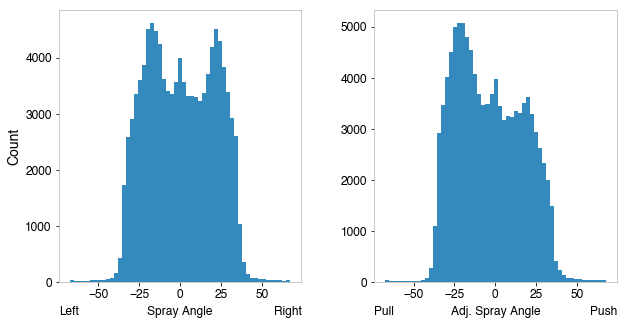

In [7]:
fig,ax_enum = plt.subplots(ncols=2,nrows=1, figsize=(10,5))
slim_df.hist("spray_angle",bins=55, ax=ax_enum[0])
ax_enum[0].set_title("")
ax_enum[0].set_xlabel("Spray Angle")
ax_enum[0].annotate("Right",xy=(1,-0.12),xycoords="axes fraction",fontsize=12,ha="right")
ax_enum[0].annotate("Left",xy=(0,-0.12),xycoords="axes fraction",fontsize=12,ha="left")
ax_enum[0].set_ylabel("Count",fontsize=14)

slim_df.hist("adj_spray_angle",bins=55, ax=ax_enum[1])
ax_enum[1].set_title("")
ax_enum[1].set_xlabel("Adj. Spray Angle")
ax_enum[1].annotate("Push",xy=(1,-0.12),xycoords="axes fraction",fontsize=12,ha="right")
ax_enum[1].annotate("Pull",xy=(0,-0.12),xycoords="axes fraction",fontsize=12,ha="left")


for ax in ax_enum:
    ax.grid(b=None)
    
plt.savefig(saveDir+"/adj_spray_angle_hist", bbox_inches='tight')

It's a lot more aysmmetric than before, which likely is something more useful for the model; it can glean a lot more from push pull tendencies than right/left. The one concession is that a very smart model might have started incorporating this information slightly already since handedness is slightly-embedded in the park factors used.

Next, retrain the model with this rather than the normal spray angle.

In [8]:
original_features = [x for x in all_feature_cols if x != 'adj_spray_angle']
adjusted_features = [x for x in all_feature_cols if x != 'spray_angle']
original_bdt = train_bdt(X_train, y_train, original_features)
adjusted_bdt = train_bdt(X_train, y_train, adjusted_features)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.3, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_class=5, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1.0, tree_method=None, validate_parameters=False,
              verbosity=None)
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, 

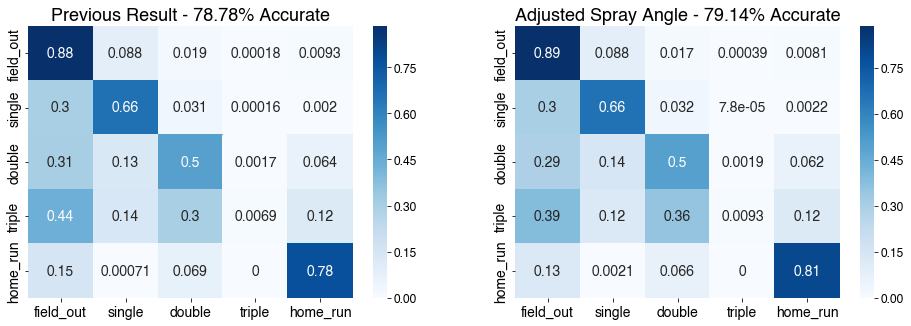

In [9]:
fig, ax_enum = plt.subplots(1,2, figsize=(16,5))
plt.sca(ax_enum[0])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(original_bdt.predict(X_test[original_features])), classnames=targets)
plt.title("Previous Result - {0:.2f}% Accurate".format(100*original_bdt.score(X_test[original_features], y_test)),fontsize=18)
plt.sca(ax_enum[1])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(adjusted_bdt.predict(X_test[adjusted_features])), classnames=targets)
_=plt.title("Adjusted Spray Angle - {0:.2f}% Accurate".format(100*adjusted_bdt.score(X_test[adjusted_features], y_test)),fontsize=18)
plt.savefig(saveDir+"/adj_spray_angle_result", bbox_inches='tight')

In [10]:
X_train = X_train.drop("spray_angle",axis=1)
X_test = X_test.drop("spray_angle",axis=1)

Good improvement of accuracy here, specifically in HRs. Good takeaway to highlight: **smart features are just as (if not more) important than smart models.**

## Now to the sampling

This I intend to make the bulk of this article. We're working with an imbalanced dataset, so it's possible that we might get improved performance by resampling. This can be done in several ways and I'll do a comparison of several. 

The one important thing to note is that since misclassifications one way or another are equivalently bad, accuracy still seems to be the metric of choice - that being given, it's unlikely any of these will perform better than the default.

### First we'll look at simple upsampling to the majority class

This means we'll balance out the classes by repeating events in the minority classes until that match that of the majority.

In [11]:
from sklearn.utils import resample
X_train["target"] = y_train
max_size = max(np.bincount(y_train))

upsampled_df = pd.DataFrame()
for target in np.unique(y_train):
    class_samples = X_train[X_train["target"] == target]
    upsampled_class_samples = resample(class_samples, 
                                 replace=True,     # sample with replacement
                                 n_samples=max_size,    # to match majority class
                                 random_state=123) # reproducible results
    upsampled_df = pd.concat([upsampled_df, upsampled_class_samples])

In [12]:
# Check to make sure it worked...
upsampled_df["target"].value_counts()

4    33087
3    33087
2    33087
1    33087
0    33087
Name: target, dtype: int64

In [13]:
y_train_upsample = np.array(upsampled_df["target"])
X_train_upsample = upsampled_df.drop("target", axis=1)

In [14]:
upsample_bdt = train_bdt(X_train_upsample, y_train_upsample, adjusted_features, task_kwargdict={'eval_set':[(X_train_upsample, y_train_upsample), (X_test,y_test)]})

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'adj_spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.3, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_class=5, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1.0, tree_method=None, validate_parameters=False,
              verbosity=None)


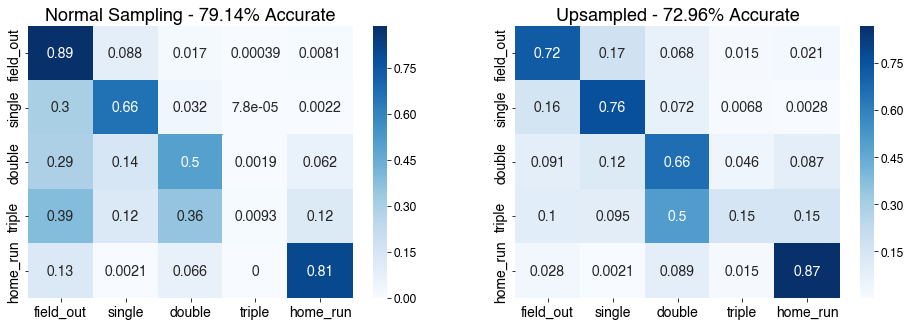

In [15]:
fig, ax_enum = plt.subplots(1,2, figsize=(16,5))
plt.sca(ax_enum[0])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(adjusted_bdt.predict(X_test[adjusted_features])), classnames=targets)
_=plt.title("Normal Sampling - {0:.2f}% Accurate".format(100*adjusted_bdt.score(X_test[adjusted_features], y_test)),fontsize=18)
plt.sca(ax_enum[1])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(upsample_bdt.predict(X_test[adjusted_features])), classnames=targets)
_=plt.title("Upsampled - {0:.2f}% Accurate".format(100*upsample_bdt.score(X_test[adjusted_features], y_test)),fontsize=18)
plt.savefig(saveDir+"/upsample_comparison", bbox_inches='tight')

The overall accuracy went down. Entirely due to worse performance on outs, every other class is doing better.

### Next downsampling

I'm generally not a proponent of downsampling, just because we're wasting data that we have, _especially_ when the minority class is so disproportionately low, but we can check it anyway.

In [16]:
min_size = min(np.bincount(y_train))
downsampled_df = pd.DataFrame()
for target in np.unique(y_train):
    class_samples = X_train[X_train["target"] == target]
    downsampled_class_samples = resample(class_samples, 
                                 replace=True,     # sample with replacement
                                 n_samples=min_size,    # to match majority class
                                 random_state=123) # reproducible results
    downsampled_df = pd.concat([downsampled_df, downsampled_class_samples])

In [17]:
# Check to make sure it worked...
downsampled_df["target"].value_counts()

3    421
1    421
4    421
2    421
0    421
Name: target, dtype: int64

In [18]:
y_train_downsample = np.array(downsampled_df["target"])
X_train_downsample = downsampled_df.drop("target", axis=1)
downsample_bdt = train_bdt(
    X_train_downsample, y_train_downsample, adjusted_features, 
    task_kwargdict={'eval_set':[(X_train_downsample, y_train_downsample), (X_test,y_test)]}
    )

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'adj_spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.3, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_class=5, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1.0, tree_method=None, validate_parameters=False,
              verbosity=None)


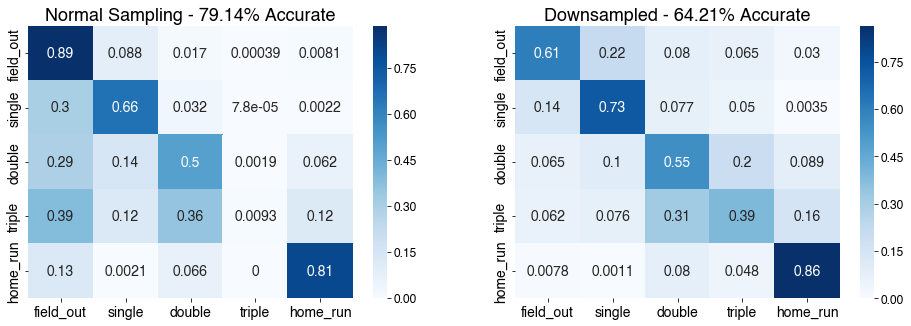

In [19]:
fig, ax_enum = plt.subplots(1,2, figsize=(16,5))
plt.sca(ax_enum[0])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(adjusted_bdt.predict(X_test[adjusted_features])), classnames=targets)
_=plt.title("Normal Sampling - {0:.2f}% Accurate".format(100*adjusted_bdt.score(X_test[adjusted_features], y_test)),fontsize=18)
plt.sca(ax_enum[1])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(downsample_bdt.predict(X_test[adjusted_features])), classnames=targets)
_=plt.title("Downsampled - {0:.2f}% Accurate".format(100*downsample_bdt.score(X_test[adjusted_features], y_test)),fontsize=18)
plt.savefig(saveDir+"/downsample_comparison", bbox_inches='tight')

This really suffered in terms of accuracy, the outs are even less accurate than the upsampled. It actually did really well with triples though, which is definitely interesting to know, but certainly makes sense.

## Trying a couple of more sophisticated resampling approaches

Honestly, the point of doing this post was so I can learn more about these methods through real life application. I'll elaborate more on what each of these are within the [final blog post](http://tylerjamesburch.com/blog/baseball/hit-classifier-3). For the purpose of this notebook, I'll just give a quick one-line explanation and code reference - these use the imbalanced-learn package.

### Start with NearMiss

This is an undersampling technique that retains data near the decision boundaries.

https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.NearMiss.html#imblearn.under_sampling.NearMiss

In [20]:
from imblearn.under_sampling import NearMiss
nm = NearMiss(sampling_strategy="auto")
X_train_NearMiss, y_train_NearMiss = nm.fit_resample(X_train, y_train)
np.bincount(y_train_NearMiss)

array([421, 421, 421, 421, 421])

In [21]:
X_train_NearMiss = X_train_NearMiss[adjusted_features]
NearMiss_bdt = train_bdt(
    X_train_NearMiss, y_train_NearMiss, adjusted_features, 
    task_kwargdict={'eval_set':[(X_train_NearMiss, y_train_NearMiss), (X_test,y_test)]}
    )

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'adj_spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.3, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_class=5, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1.0, tree_method=None, validate_parameters=False,
              verbosity=None)


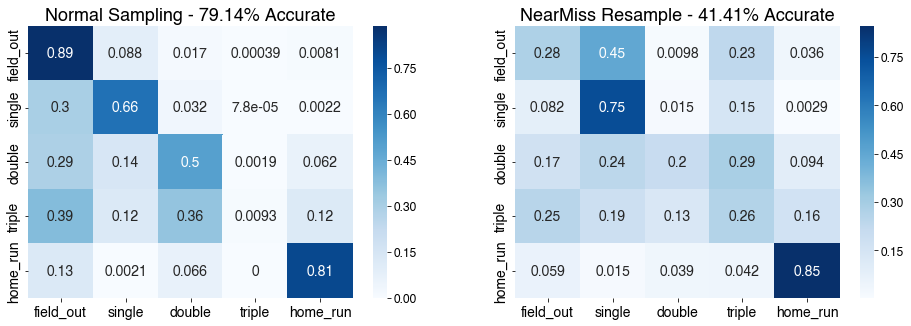

In [22]:
fig, ax_enum = plt.subplots(1,2, figsize=(16,5))
plt.sca(ax_enum[0])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(adjusted_bdt.predict(X_test[adjusted_features])), classnames=targets)
_=plt.title("Normal Sampling - {0:.2f}% Accurate".format(100*adjusted_bdt.score(X_test[adjusted_features], y_test)),fontsize=18)
plt.sca(ax_enum[1])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(NearMiss_bdt.predict(X_test[adjusted_features])), classnames=targets)
_=plt.title("NearMiss Resample - {0:.2f}% Accurate".format(100*NearMiss_bdt.score(X_test[adjusted_features], y_test)),fontsize=18)
plt.savefig(saveDir+"/nearmiss_comparison", bbox_inches='tight')

Truly terrible. It did well for singles and home runs, but the other sampling techniques did better. Quick plot to understand why this method is so bad here....

In [23]:
nm_combined = X_train_NearMiss.copy()
nm_combined["target"] = le.inverse_transform(y_train_NearMiss)
nm_combined_outs = nm_combined[nm_combined["target"]=="field_out"]

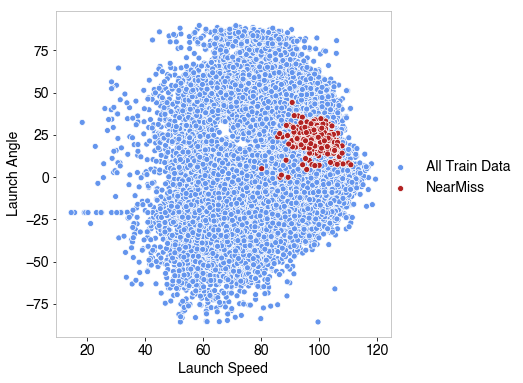

In [24]:
X_train_outs = X_train[y_train==1]
fig=plt.figure(figsize=(6,6))
ax = plt.gca()
sns.scatterplot(x='launch_speed', y='launch_angle',hue="target",
           data=X_train_outs, markers={"s": 10, "alpha" : 0.1}, legend=None,ax=ax, palette=["cornflowerblue"])
sns.scatterplot(x='launch_speed', y='launch_angle',hue="target",
           data=nm_combined_outs, markers={"s": 10}, legend=None,ax=ax, palette=["firebrick"])
plt.xlabel("Launch Speed",fontsize=14)
plt.ylabel("Launch Angle",fontsize=14)
plt.tick_params(labelsize=14)

#colors=["cornflowerblue","firebrick"]
labels=["All Train Data", "NearMiss"]
plt.legend(labels, fontsize=14,bbox_to_anchor=(0.95,0.58),frameon=False)
plt.savefig(saveDir+"/nearmiss_outs", bbox_inches='tight')

It's very obvious why this did so poorly - the field outs that it kept are near the ambiguous spot between outs and various hit types, which doesn't cover the full field out sample space.

### SMOTE

"Synthetic Minority Oversampling Technique" - Generates fake data that is similar to, but not exactly like the minority class. Uses a nearest-neighbors approach and fills in space between neighbors.

https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html#imblearn.over_sampling.SMOTE

In [25]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy="auto")
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
np.bincount(y_train_smote)

array([33087, 33087, 33087, 33087, 33087])

In [26]:
X_train_smote = X_train_smote[adjusted_features]
smote_bdt = train_bdt(
    X_train_smote, y_train_smote, adjusted_features, 
    task_kwargdict={'eval_set':[(X_train_smote, y_train_smote), (X_test,y_test)]}
    )

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'adj_spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.3, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_class=5, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1.0, tree_method=None, validate_parameters=False,
              verbosity=None)


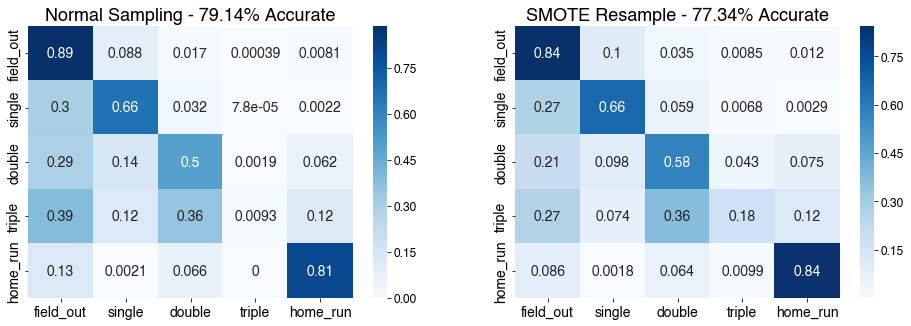

In [27]:
fig, ax_enum = plt.subplots(1,2, figsize=(16,5))
plt.sca(ax_enum[0])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(adjusted_bdt.predict(X_test[adjusted_features])), classnames=targets)
_=plt.title("Normal Sampling - {0:.2f}% Accurate".format(100*adjusted_bdt.score(X_test[adjusted_features], y_test)),fontsize=18)
plt.sca(ax_enum[1])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(smote_bdt.predict(X_test[adjusted_features])), classnames=targets)
_=plt.title("SMOTE Resample - {0:.2f}% Accurate".format(100*smote_bdt.score(X_test[adjusted_features], y_test)),fontsize=18)
plt.savefig(saveDir+"/smote_comparison", bbox_inches='tight')

This is the best resample so far, in terms of accuracy. Everything but outs are better, however the amount of incorrect outs makes the overall accuracy decrease.

### ADASYN

Adaptive Synthetic Sampling - Similar to SMOTE, but focuses on data that are hard to learn


https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.ADASYN.html

In [28]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(sampling_strategy="auto")
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
np.bincount(y_train_adasyn)

array([32198, 33087, 33107, 33281, 33129])

In [29]:
X_train_adasyn = X_train_adasyn[adjusted_features]
adasyn_bdt = train_bdt(
    X_train_adasyn, y_train_adasyn, adjusted_features, 
    task_kwargdict={'eval_set':[(X_train_adasyn, y_train_adasyn), (X_test,y_test)]}
    )

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'adj_spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.3, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_class=5, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1.0, tree_method=None, validate_parameters=False,
              verbosity=None)


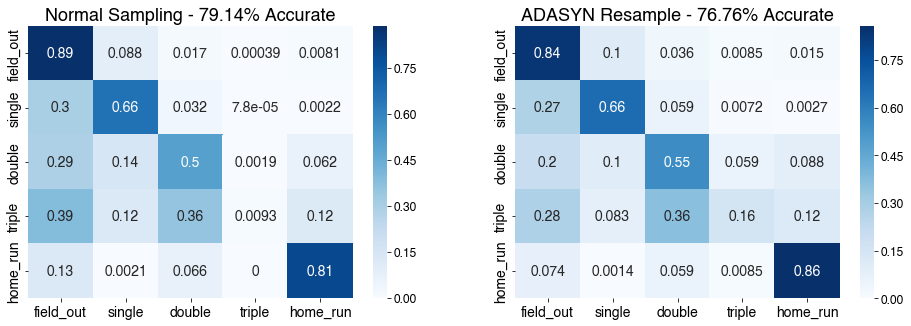

In [30]:
fig, ax_enum = plt.subplots(1,2, figsize=(16,5))
plt.sca(ax_enum[0])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(adjusted_bdt.predict(X_test[adjusted_features])), classnames=targets)
_=plt.title("Normal Sampling - {0:.2f}% Accurate".format(100*adjusted_bdt.score(X_test[adjusted_features], y_test)),fontsize=18)
plt.sca(ax_enum[1])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(adasyn_bdt.predict(X_test[adjusted_features])), classnames=targets)
_=plt.title("ADASYN Resample - {0:.2f}% Accurate".format(100*adasyn_bdt.score(X_test[adjusted_features], y_test)),fontsize=18)
plt.savefig(saveDir+"/smote_comparison", bbox_inches='tight')

This method ends up a bit worse than SMOTE or normal upsampling.

I'd like to plot these over one another to compare, unfortunately that plot gets very messsy very quickly...

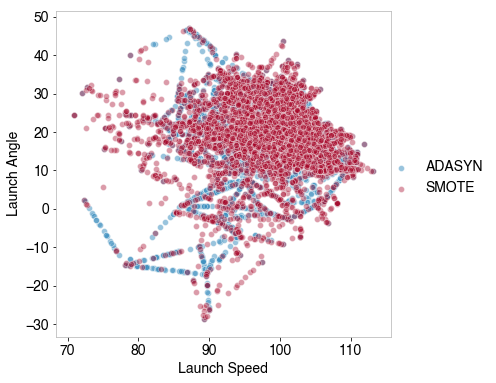

In [31]:
X_train_adasyn_t = X_train_adasyn[y_train_adasyn==4][0:5000]
X_train_smote_t = X_train_smote[y_train_smote==4][0:5000]

fig=plt.figure(figsize=(6,6))
ax = plt.gca()
sns.scatterplot(x='launch_speed', y='launch_angle',
           data=X_train_adasyn_t, markers={"s": 10}, legend=None,ax=ax, palette=["cornflowerblue"], alpha=0.5)
sns.scatterplot(x='launch_speed', y='launch_angle',
           data=X_train_smote_t, markers={"s": 10}, legend=None,ax=ax, palette=["firebrick"], alpha=0.4)
plt.xlabel("Launch Speed",fontsize=14)
plt.ylabel("Launch Angle",fontsize=14)
plt.tick_params(labelsize=14)

#colors=["cornflowerblue","firebrick"]
labels=["ADASYN", "SMOTE"]
plt.legend(labels, fontsize=14,bbox_to_anchor=(0.95,0.58),frameon=False)
plt.savefig(saveDir+"/smote_v_adasyn", bbox_inches='tight')

One thing to note here is that SMOTE is a bit more broad and out there with the generated data, where SMOTE seems to stay within the range we expect for these values. By too much focus on the "hard to predict" data, it overcompensates since our classes are so imbalanced.

Next we'll make a quick comparison plot...

In [32]:
from collections import OrderedDict
scores = OrderedDict()
scores["No Resampling"] =  100*adjusted_bdt.score(X_test[adjusted_features], y_test)
scores["SMOTE"] = 100*smote_bdt.score(X_test[adjusted_features], y_test)
scores["ADASYN"] =  100*adasyn_bdt.score(X_test[adjusted_features], y_test)
scores["Raw\nUpsample"] = 100*upsample_bdt.score(X_test[adjusted_features], y_test)
scores["Raw\nDownsample"] = 100*downsample_bdt.score(X_test[adjusted_features], y_test)
scores["NearMiss"] = 100*NearMiss_bdt.score(X_test[adjusted_features], y_test)

In [33]:
[ f"{v}" for v in list(scores.values())]
#[ f"{v[0]:.2f}%" for v in list(scores.values())]

['79.13752695228274',
 '77.3357082591169',
 '76.7638511296522',
 '72.95772007124778',
 '64.21486828536608',
 '41.406206056060746']

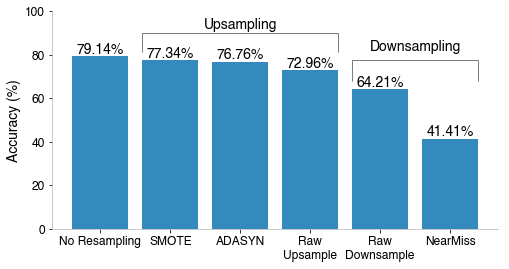

In [34]:
fig = plt.figure(figsize=(8,4))
plt.bar(scores.keys(), scores.values())
plt.ylabel("Accuracy (%)",fontsize=14)
plt.ylim(top=100)


plt.gca().annotate("",
            xy=(0.6, 63), xycoords='data',
            xytext=(3.4, 63), textcoords='data',
            arrowprops=dict(arrowstyle="-",
                            connectionstyle="bar",
                            color="black",
                            shrinkA=40,
                            shrinkB=40,
                           ),
            )
plt.gca().annotate("Upsampling", xy=(2,92),
                   xycoords='data',ha='center',fontsize=14)


plt.gca().annotate("",
            xy=(3.6, 60), xycoords='data',
            xytext=(5.4, 60), textcoords='data',
            arrowprops=dict(arrowstyle="-",
                            connectionstyle="bar",
                            color="black",
                            shrinkA=17,
                            shrinkB=17,
                           ),
            )
plt.gca().annotate("Downsampling", xy=(4.5,82),
                   xycoords='data',ha='center',fontsize=14)

sns.despine()

labels = [ f"{v:.2f}%" for v in scores.values()]
rects = plt.gca().patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    plt.gca().text(rect.get_x() + rect.get_width() / 2, height, label,
                   ha='center', va='bottom',fontsize=14)

plt.savefig(saveDir+"/single_sampling_comparison", bbox_inches='tight')

Upsampling definitely is the better of the two options, but definitely a penalty compared to not performing any. Using more intelligent upsampling (SMOTE and ADASYN) is better than just raw upsampling

## 2 Classifier approach

Use a binary classifier for hit/not hit, then imbalanced multiclassifer for the hit-type. In part 2 I found the best model was still a BDT, and will quickly recreate that work. This reduces the problem from a large imbalanced problem to one balanced binary problem and one imbalanced multiclassification problem.

### Binary Classifier

Train this once and done.

In [35]:
out_label = list(le.classes_).index("field_out")

binary_y_train = (y_train != out_label).astype(int)
binary_y_test = (y_test != out_label).astype(int)

In [36]:
binary_bdt_param = {
    "learning_rate" : 0.15,
    "max_depth" : 6,
    "colsample_bytree" : 1.0,
    "subsample" : 1.0,
    "n_estimators" : 200,
    "feature_names" : adjusted_features,
}
binary_task_param = {
    "eval_metric" : ["logloss","error"],
    "early_stopping_rounds" : 30,
    "eval_set": [(X_train[adjusted_features],binary_y_train), 
                 (X_test[adjusted_features],binary_y_test)]
}

binary_bdt = xgb.XGBClassifier(**binary_bdt_param)
binary_bdt.fit(X_train[adjusted_features], binary_y_train,
              verbose=False, **binary_task_param)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'adj_spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.15,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method=None, validate_parameters=False, verbosity=None)

In [37]:
evaluated_df = X_test.copy()
evaluated_df["binary_prob"] = binary_bdt.predict_proba(X_test[adjusted_features])[:,1]
print(binary_bdt.score(X_test[adjusted_features],binary_y_test))

0.8238117558826287


In [38]:
np.bincount(binary_y_test)

array([33134, 20201])

We start with an 82.4% overal accuracy from the binary classifier.

### Multiclass

Here we'll train using all of the above methods to see if we can get any improvement here.

In [39]:
X_train_hitonly = X_train[binary_y_train.astype(bool)]
X_test_hitonly = X_test[binary_y_test.astype(bool)]
y_train_hitonly = y_train[binary_y_train.astype(bool)]
y_test_hitonly = y_test[binary_y_test.astype(bool)]
print(np.bincount(y_train_hitonly))

Doing many trainings, so define a function to automate that a bit.

In [41]:
def train_hitclass_bdt(X_train, y_train, X_test, y_test):
    bdt_param = {
        "learning_rate" : 0.15,
        "max_depth" : 3,
        "colsample_bytree" : 1.0,
        "subsample" : 1.0,
        "n_estimators" : 200,
        "feature_names" : adjusted_features,
    }
    task_param = {
        "eval_metric" : ["mlogloss","merror"],
        "early_stopping_rounds" : 30,
        "eval_set": [(X_train[adjusted_features], y_train), 
                     (X_test[adjusted_features], y_test)]
    }
    
    bdt = xgb.XGBClassifier(**bdt_param)
    bdt.fit(X_train[adjusted_features], y_train, verbose=False, **task_param) 
    print(bdt)
    return bdt

In [42]:
default_multi_bdt = train_hitclass_bdt(X_train_hitonly, y_train_hitonly,
                                       X_test_hitonly, y_test_hitonly)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'adj_spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.15,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1.0,
              tree_method=None, validate_parameters=False, verbosity=None)


In [43]:
from sklearn.metrics import accuracy_score
def evaluate_score(df, mc_bdt):
    evaluated_df = df.copy()    
    evaluated_df["binary_decision"] = binary_bdt.predict(df[adjusted_features])
    evaluated_df["multiclass_decision"] = mc_bdt.predict(df[adjusted_features])
    evaluated_df["final_decision"] =  evaluated_df.apply(lambda row: row["multiclass_decision"] if row["binary_decision"] == 1 else 1, axis=1)
    return accuracy_score(y_test, evaluated_df["final_decision"])

In [44]:
default_multi_acc = evaluate_score(X_test, default_multi_bdt)
print(f"Default multi-level accuracy is {default_multi_acc:.4f}")

Default multi-level accuracy is 0.7872


1. Upsampling

In [45]:
X_train_hitonly["target"] = y_train_hitonly
max_size = max(np.bincount(y_train_hitonly))

upsampled_df = pd.DataFrame()
for target in np.unique(y_train_hitonly):
    class_samples = X_train_hitonly[X_train_hitonly["target"] == target]
    upsampled_class_samples = resample(class_samples, 
                                       replace=True,     # sample with replacement
                                       n_samples=max_size,    # to match majority class
                                       random_state=123) # reproducible results
    upsampled_df = pd.concat([upsampled_df, upsampled_class_samples])
    
yhit_train_upsample = np.array(upsampled_df["target"])
Xhit_train_upsample = upsampled_df.drop("target", axis=1)

/Users/tburch/Documents/gitDevelopment/baseball-studies/venv_py3_baseball/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [46]:
np.bincount(yhit_train_upsample) # Just to be sure this handles the 0 okay...

array([12769,     0, 12769, 12769, 12769])

In [47]:
upsample_multi_bdt = train_hitclass_bdt(Xhit_train_upsample, yhit_train_upsample,
                                        X_test_hitonly, y_test_hitonly)
upsample_multi_acc = evaluate_score(X_test, upsample_multi_bdt)
print(f"Upsample multi-level accuracy is {upsample_multi_acc:.4f}")

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'adj_spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.15,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1.0,
              tree_method=None, validate_parameters=False, verbosity=None)
Upsample multi-level accuracy is 0.7741


Still worse than default, but better than any resampled 1-model approach

2. Downsampling

In [48]:
bc = np.bincount(y_train_hitonly)
min_size = min(bc[bc!=0]) # Get rid of 0 value from outs
downsampled_df = pd.DataFrame()
for target in np.unique(y_train_hitonly):
    class_samples = X_train_hitonly[X_train_hitonly["target"] == target]
    downsampled_class_samples = resample(class_samples, 
                                 replace=True,     # sample with replacement
                                 n_samples=min_size,    # to match majority class
                                 random_state=123) # reproducible results
    downsampled_df = pd.concat([downsampled_df, downsampled_class_samples])
    
yhit_train_downsample = np.array(downsampled_df["target"])
Xhit_train_downsample = downsampled_df.drop("target", axis=1)

downsample_multi_bdt = train_hitclass_bdt(Xhit_train_downsample, yhit_train_downsample,
                                          X_test_hitonly, y_test_hitonly)
downsample_multi_acc = evaluate_score(X_test, downsample_multi_bdt)
print(f"Downsample multi-level accuracy is {downsample_multi_acc:.4f}")

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'adj_spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.15,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1.0,
              tree_method=None, validate_parameters=False, verbosity=None)
Downsample multi-level accuracy is 0.7648


3. Alternate sampling methods

In [49]:
X_train_hitonly.drop("target",axis=1)
# Nearmiss
nm_hit = NearMiss(sampling_strategy="auto")
Xhit_train_NearMiss, yhit_train_NearMiss = nm.fit_resample(X_train_hitonly, y_train_hitonly)
np.bincount(yhit_train_NearMiss)

array([421,   0, 421, 421, 421])

In [50]:
nearmiss_multi_bdt = train_hitclass_bdt(Xhit_train_NearMiss, yhit_train_NearMiss,
                                        X_test_hitonly, y_test_hitonly)
nearmiss_multi_acc = evaluate_score(X_test, nearmiss_multi_bdt)
print(f"NearMiss multi-level accuracy is {nearmiss_multi_acc:.4f}")

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'adj_spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.15,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1.0,
              tree_method=None, validate_parameters=False, verbosity=None)
NearMiss multi-level accuracy is 0.7328


In [51]:
smote = SMOTE(sampling_strategy="auto")
Xhit_train_smote, yhit_train_smote = smote.fit_resample(X_train_hitonly, y_train_hitonly)
print(f"bincount check: {np.bincount(yhit_train_smote)}")
smote_multi_bdt = train_hitclass_bdt(Xhit_train_smote, yhit_train_smote,
                                     X_test_hitonly, y_test_hitonly)
smote_multi_acc = evaluate_score(X_test, smote_multi_bdt)
print(f"SMOTE multi-level accuracy is {smote_multi_acc:.4f}")

bincount check: [12769     0 12769 12769 12769]
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'adj_spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.15,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1.0,
              tree_method=None, validate_parameters=False, verbosity=None)
SMOTE multi-level accuracy is 0.7773


In [52]:
adasyn = ADASYN(sampling_strategy="auto")
Xhit_train_adasyn, yhit_train_adasyn = adasyn.fit_resample(X_train_hitonly, y_train_hitonly)
print(f"bincount check: {np.bincount(yhit_train_adasyn)}")
adasyn_multi_bdt = train_hitclass_bdt(Xhit_train_adasyn, yhit_train_adasyn,
                                     X_test_hitonly, y_test_hitonly)
adasyn_multi_acc = evaluate_score(X_test, adasyn_multi_bdt)
print(f"ADASYN multi-level accuracy is {adasyn_multi_acc:.4f}")

bincount check: [12106     0 12975 12769 12830]
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'adj_spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.15,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1.0,
              tree_method=None, validate_parameters=False, verbosity=None)
ADASYN multi-level accuracy is 0.7746


### Make a final Comparison Plot

In [53]:
scores = OrderedDict()
scores["No Resampling"] =  100*default_multi_acc
scores["SMOTE"] = 100*smote_multi_acc
scores["ADASYN"] =  100*adasyn_multi_acc
scores["Raw\nUpsample"] = 100*upsample_multi_acc
scores["Raw\nDownsample"] = 100*downsample_multi_acc
scores["NearMiss"] = 100*nearmiss_multi_acc

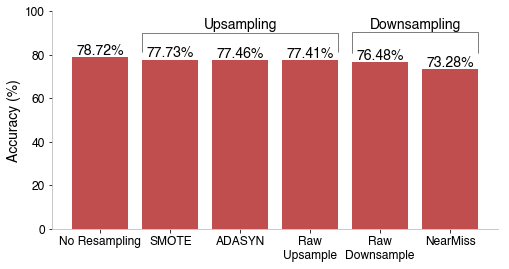

In [54]:
fig = plt.figure(figsize=(8,4))
plt.bar(scores.keys(), scores.values(),color="firebrick",alpha=0.8)
plt.ylabel("Accuracy (%)",fontsize=14)
plt.ylim(top=100)


plt.gca().annotate("",
            xy=(0.6, 63), xycoords='data',
            xytext=(3.4, 63), textcoords='data',
            arrowprops=dict(arrowstyle="-",
                            connectionstyle="bar",
                            color="black",
                            shrinkA=40,
                            shrinkB=40,
                           ),
            )
plt.gca().annotate("Upsampling", xy=(2,92),
                   xycoords='data',ha='center',fontsize=14)


plt.gca().annotate("",
            xy=(3.6, 73), xycoords='data',
            xytext=(5.4, 73), textcoords='data',
            arrowprops=dict(arrowstyle="-",
                            connectionstyle="bar",
                            color="black",
                            shrinkA=17,
                            shrinkB=17,
                           ),
            )
plt.gca().annotate("Downsampling", xy=(4.5,92),
                   xycoords='data',ha='center',fontsize=14)

labels = [ f"{v:.2f}%" for v in scores.values()]
rects = plt.gca().patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    plt.gca().text(rect.get_x() + rect.get_width() / 2, height, label,
                   ha='center', va='bottom',fontsize=14)

sns.despine()
plt.savefig(saveDir+"/multi_sampling_comparison", bbox_inches='tight')

Progression of which methods do best match the single-model approach. Since we start with nearly 27,300 correct predictions by using the binary classifier though, the baseline is much higher. All upsampling techniques are better than the best 1-model technique.